# Image Segmentation with U-Net

Welcome to the final assignment of Week 3! You'll be building your own U-Net, a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset. 

This type of image classification is called semantic image segmentation. It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class. The word “semantic” here refers to what's being shown, so for example the “Car” class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:

<img src="images/carseg.png" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

As you might imagine, region-specific labeling is a pretty crucial consideration for self-driving cars, which require a pixel-perfect understanding of their environment so they can change lanes and avoid other cars, or any number of traffic obstacles that can put peoples' lives in danger. 

By the time you finish this notebook, you'll be able to: 

* Build your own U-Net
* Explain the difference between a regular CNN and a U-net
* Implement semantic image segmentation on the CARLA self-driving car dataset
* Apply sparse categorical crossentropy for pixelwise prediction

Onward, to this grand and glorious quest!

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader Error: Grader feedback not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/convolutional-neural-networks/supplement/DS4yP/h-ow-to-refresh-your-workspace).

## Table of Content

- [1 - Packages](#1)
- [2 - Load and Split the Data](#2)
    - [2.1 - Split Your Dataset into Unmasked and Masked Images](#2-1)
    - [2.2 - Preprocess Your Data](#2-2)
- [3 - U-Net](#3)
    - [3.1 - Model Details](#3-1)
    - [3.2 - Encoder (Downsampling Block)](#3-2)
        - [Exercise 1 - conv_block](#ex-1)
    - [3.3 - Decoder (Upsampling Block)](#3-3)
        - [Exercise 2 - upsampling_block](#ex-2)
    - [3.4 - Build the Model](#3-4)
        - [Exercise 3 - unet_model](#ex-3)
    - [3.5 - Set Model Dimensions](#3-5)
    - [3.6 - Loss Function](#3-6)
    - [3.7 - Dataset Handling](#3-7)
- [4 - Train the Model](#4)
    - [4.1 - Create Predicted Masks](#4-1)
    - [4.2 - Plot Model Accuracy](#4-2)
    - [4.3 - Show Predictions](#4-3)

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [2]:
### v1.1

In [3]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

<a name='2'></a>
## 2 - Load and Split the Data

In [4]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=2`. Otherwise the autograder will throw a `list index out of range` error.

Text(0.5, 1.0, 'Segmentation')

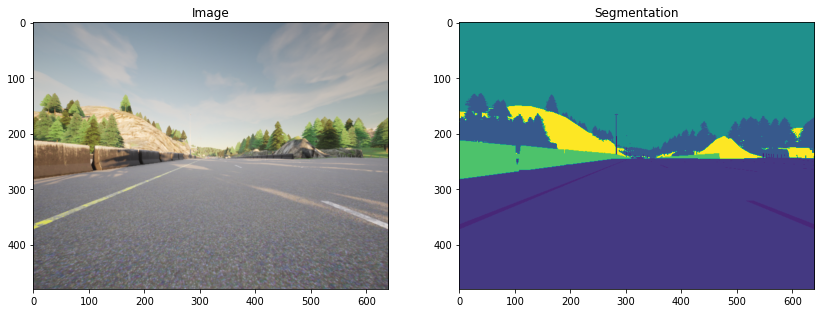

In [5]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-1'></a>
### 2.1 - Split Your Dataset into Unmasked and Masked Images

In [6]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)


In [7]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/002128.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/002128.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocess Your Data

Normally, you normalize your image values by dividing them by `255`. This sets them between `0` and `1`. However, using `tf.image.convert_image_dtype` with `tf.float32` sets them between `0` and `1` for you, so there's no need to further divide them by `255`.

In [8]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

<a name='3'></a>
## 3 - U-Net 

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting. 

<a name='3-1'></a>
### 3.1 - Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 same padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total.

#### Important Note: 
The figures shown in the assignment for the U-Net architecture depict the layer dimensions and filter sizes as per the original paper on U-Net with smaller images. However, due to computational constraints for this assignment, you will code only half of those filters. The purpose of showing you the original dimensions is to give you the flavour of the original U-Net architecture. The important takeaway is that you multiply by 2 the number of filters used in the previous step. The notebook includes all of the necessary instructions and hints to help you code the U-Net architecture needed for this assignment.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

<a name='ex-1'></a>
### Exercise 1 - conv_block

Implement `conv_block(...)`. Here are the instructions for each step in the `conv_block`, or contracting block: 

* Add 2 **Conv2D** layers with `n_filters` filters with `kernel_size` set to 3, `kernel_initializer` set to ['he_normal'](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), `padding` set to 'same' and 'relu' activation.
* if `dropout_prob` > 0, then add a Dropout layer with parameter `dropout_prob`
* If `max_pooling` is set to True, then add a MaxPooling2D layer with 2x2 pool size

In [9]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size=3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size=3,   # Kernel size
                  activation='relu',
                  padding='same',
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [10]:
input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 96, 128, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]]
           
print('\nBlock 2:')   
for layer in summary(model2):
    print(layer)
    
comparator(summary(model2), output2)

Block 1:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]
All tests passed!

Block 2:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal']
['Dropout', (None, 96, 128, 1024), 0, 0.1]
['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]
All tests passed!


<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

Here you'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer. You can read more about it [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)


<a name='ex-2'></a>
### Exercise 2 - upsampling_block

Implement `upsampling_block(...)`.

For the function `upsampling_block`: 
* Takes the arguments `expansive_input` (which is the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer)
* The number of filters here is the same as in the downsampling block you completed previously
* Your `Conv2DTranspose` layer will take `n_filters` with shape (3,3) and a stride of (2,2), with padding set to `same`. It's applied to `expansive_input`, or the input tensor from the previous layer. 

This block is also where you'll concatenate the outputs from the encoder blocks, creating skip connections. 

* Concatenate your Conv2DTranspose layer output to the contractive input, with an `axis` of 3. In general, you can concatenate the tensors in the order that you prefer. But for the grader, it is important that you use `[up, contractive_input]`

For the final component, set the parameters for two Conv2D layers to the same values that you set for the two Conv2D layers in the encoder (ReLU activation, He normal initializer, `same` padding). 


In [11]:
# UNQ_C2
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 kernel_size=(3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 kernel_size=(3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 kernel_size=(3,3),   # Kernel size
                 activation='relu',
                 padding='same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    return conv

In [12]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 12, 16, 256)], 0],
            ['Conv2DTranspose', (None, 24, 32, 32), 73760],
            ['InputLayer', [(None, 24, 32, 128)], 0],
            ['Concatenate', (None, 24, 32, 160), 0],
            ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

Block 1:
['InputLayer', [(None, 12, 16, 256)], 0]
['Conv2DTranspose', (None, 24, 32, 32), 73760]
['InputLayer', [(None, 24, 32, 128)], 0]
['Concatenate', (None, 24, 32, 160), 0]
['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']
All tests passed!


<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. That's because there are 23 possible labels for each pixel in this self-driving car dataset. 

<a name='ex-3'></a>
### Exercise 3 - unet_model

For the function `unet_model`, specify the input shape, number of filters, and number of classes (23 in this case).

For the first half of the model:

* Begin with a conv block that takes the inputs of the model and the number of filters
* Then, chain the first output element of each block to the input of the next convolutional block
* Next, double the number of filters at each step
* Beginning with `conv_block4`, add `dropout_prob` of 0.3
* For the final conv_block, set `dropout_prob` to 0.3 again, and turn off max pooling  

For the second half:

* Use cblock5 as expansive_input and cblock4 as contractive_input, with `n_filters` * 8. This is your bottleneck layer. 
* Chain the output of the previous block as expansive_input and the corresponding contractive block output.
* Note that you must use the second element of the contractive block before the max pooling layer. 
* At each step, use half the number of filters of the previous block
* `conv9` is a Conv2D layer with ReLU activation, He normal initializer, `same` padding
* Finally, `conv10` is a Conv2D that takes the number of classes as the filter, a kernel size of 1, and "same" padding. The output of `conv10` is the output of your model. 

In [13]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob =0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob =0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters )
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, kernel_size=(1,1), padding='same')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [14]:
import outputs
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
comparator(summary(unet), outputs.unet_model_output)


All tests passed!


<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [15]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Check out the model summary below! 

In [16]:
unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_26 (Conv2D)             (None, 96, 128, 32)  896         ['input_6[0][0]']                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_26[0][0]']              
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_27[0][0]']        

<a name='3-6'></a>
### 3.6 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, you'll use sparse categorical crossentropy as your loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes.

In [17]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<a name='3-7'></a>
### 3.7 - Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [18]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


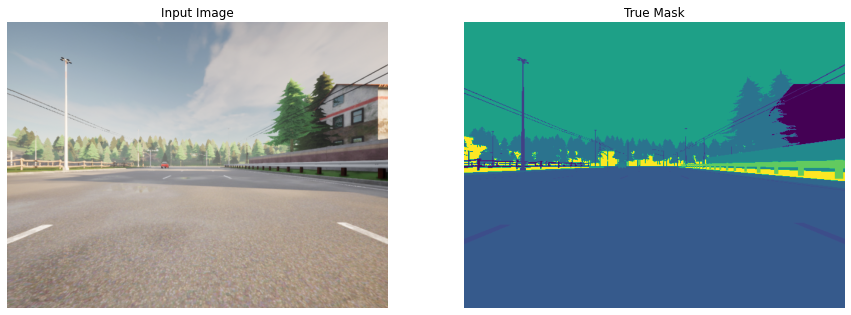

In [19]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


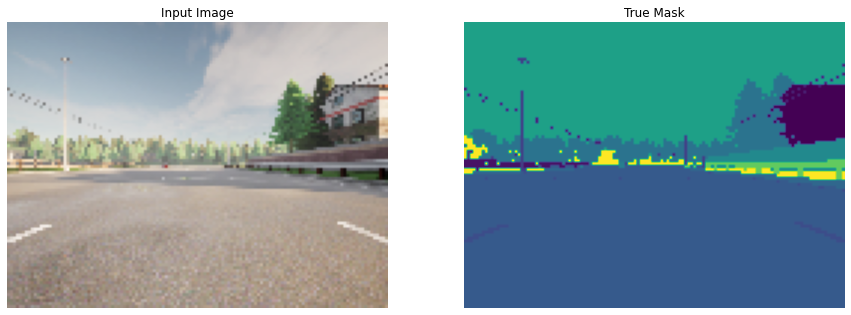

In [20]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## 4 - Train the Model

In [21]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/5
34/34 [==============================] - 18s 196ms/step - loss: 1.8129 - accuracy: 0.5676
Epoch 2/5
34/34 [==============================] - 2s 49ms/step - loss: 0.8687 - accuracy: 0.7601
Epoch 3/5
34/34 [==============================] - 2s 49ms/step - loss: 0.6098 - accuracy: 0.8325
Epoch 4/5
34/34 [==============================] - 2s 49ms/step - loss: 0.4719 - accuracy: 0.8639
Epoch 5/5
34/34 [==============================] - 2s 49ms/step - loss: 0.4000 - accuracy: 0.8837


<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [22]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how your model did! 

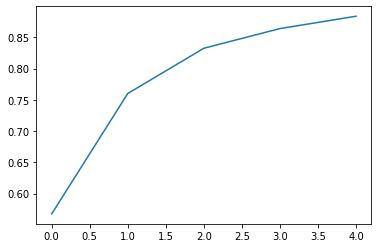

In [23]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
### 4.3 - Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

In [24]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 218ms/step


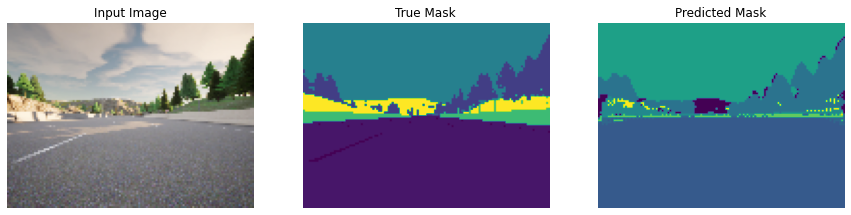

1/1 [==============================] - 0s 20ms/step


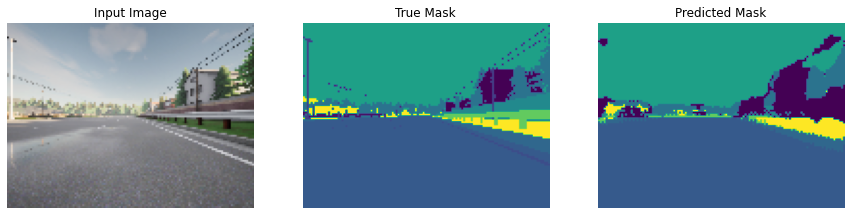

1/1 [==============================] - 0s 20ms/step


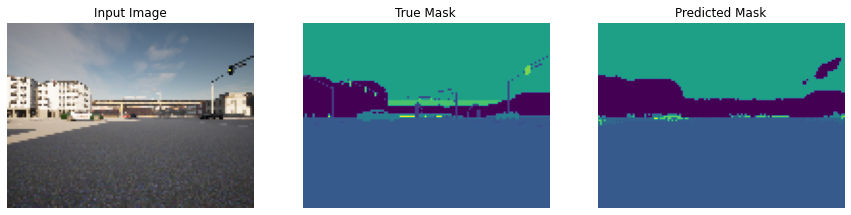

1/1 [==============================] - 0s 20ms/step


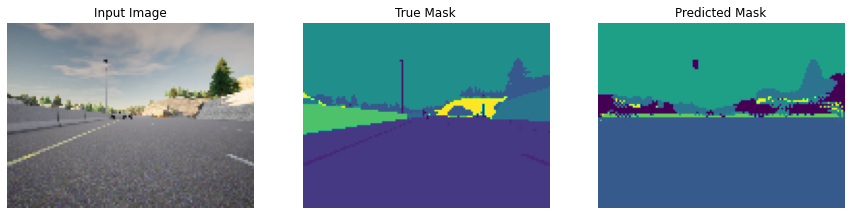

1/1 [==============================] - 0s 20ms/step


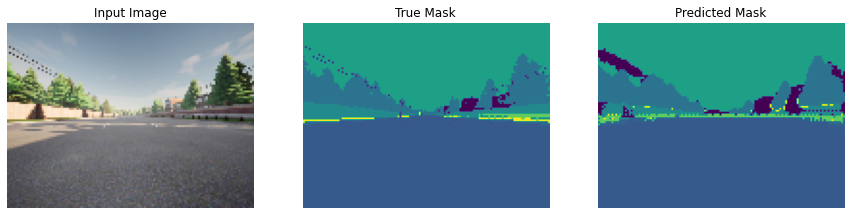

1/1 [==============================] - 0s 20ms/step


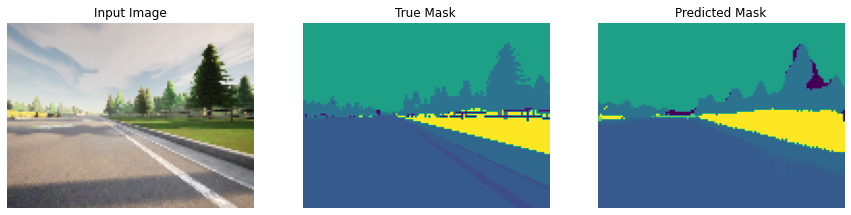

In [25]:
show_predictions(train_dataset, 6)

With 40 epochs you get amazing results!


## Free Up Resources for Other Learners

In order to provide our learners a smooth learning experience, please free up the resources used by your assignment by running the cell below so that the other learners can take advantage of those resources just as much as you did. Thank you!

**Note**: 
- Run the cell below when you are done with the assignment and are ready to submit it for grading.
- When you'll run it, a pop up will open, click `Ok`.
- Running the cell will `restart the kernel`.

In [ ]:
%%javascript
IPython.notebook.save_checkpoint();
if (confirm("Clear memory?") == true)
{
    IPython.notebook.kernel.restart();
}

### Conclusion 

You've come to the end of this assignment. Awesome work creating a state-of-the art model for semantic image segmentation! This is a very important task for self-driving cars to get right. Elon Musk will surely be knocking down your door at any moment. ;) 

<font color='blue'>
    
**What you should remember**: 

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net